RSTDP

In [1]:
import pymonntorch as pmt
import torch
# import matplotlib.pyplot as plt

In [2]:
from timeresolution import Timeresolution
from current import ConstanceCurrent,UniformCurrent
from lif import LIF
from synapse_group import FullConnectivityFirstOption, FullConnectivitySecondOption, Scaling, FixedAAndFinite
from dandrite import Dandrite
from populationactivity import PopulationActivity
from encoding import TimeToFirstSpike, NumericalCoding, PoissonDistribution
from learning_rule import STDP, RSTDP
from count_spikes import CountSpikes
from plot2 import plot
from read_image import GetImage

In [3]:
data1 = torch.tensor([[ *torch.randperm(50),*[0]*50],
                                           [ *[0]*50,*torch.randperm(50)*2],
                                           ])

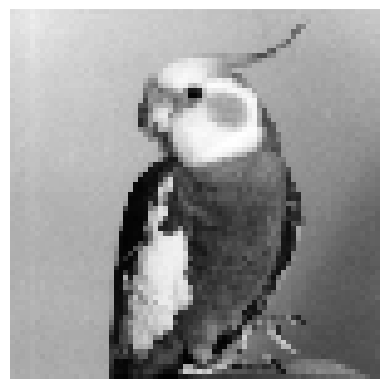

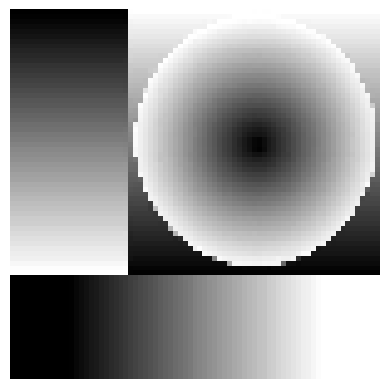

tensor([[192, 184, 177, 171, 169, 163, 158, 152, 155, 160, 180, 175, 169, 162,
         189, 167, 129, 144, 142, 147, 173, 167, 165, 137,  95, 147, 205, 141,
         136, 140, 169, 162, 160, 157, 175, 205, 204, 134, 128, 125, 159, 158,
         156, 100,  67,  99,  98,  60, 120, 112, 154, 149, 148,  18,  43,  51,
          61,  43, 112,  95, 151, 147, 146,  92, 199,  53,  78,  29,  98,  84,
         150, 148, 144, 156, 180,  52,  68, 105,  84,  81, 148, 147, 146, 152,
          60,  98,  92,  91,  77,  75, 145, 146, 141,  57,  47,  66,  94,  77,
          95,  73],
        [ 12,  12,  12, 238, 238, 252, 237, 246, 238, 238,  50,  50,  50, 202,
         230, 184, 161, 174, 212, 202,  87,  87,  87, 183, 186, 123,  84, 104,
         162, 230, 123, 123, 123, 241, 166,  90,  16,  62, 138, 214, 160, 160,
         160, 181, 178, 112,  67,  90, 152, 224, 196, 196, 196,  59, 217, 167,
         142, 154, 196,  59, 233, 233, 233,  23,  23, 235, 217, 225,  23,  23,
           0,   0,  33,  71, 108

In [4]:
data2 = torch.tensor(
    [GetImage(image_address="birdthumb.png", prefix='./images/'),
    GetImage(image_address="slopethumb.png", prefix='./images/')]
)
data2

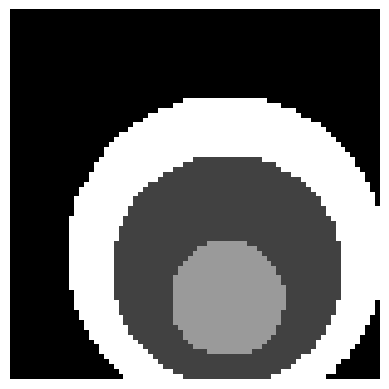

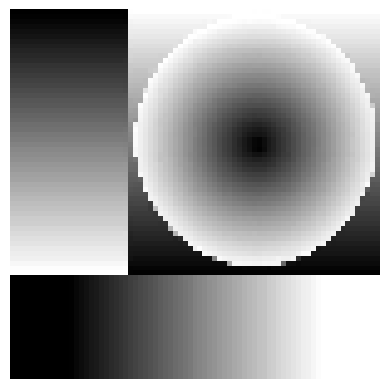

tensor([[ 20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,
          20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  74, 235, 235,  20,
          20,  20,  20,  20,  20, 235, 235, 235, 235, 235, 235,  20,  20,  20,
         235, 235,  75,  75,  75,  75, 235, 235,  20,  20, 235,  75,  75,  75,
          75,  75, 115, 235,  20,  20, 235,  75,  75, 150, 150,  75,  75, 235,
          20,  20, 235,  75, 150, 150, 150,  89,  75, 235,  20,  20, 235,  75,
         136, 150, 150,  75,  85, 235,  20,  20,  34, 235,  75,  75,  75,  75,
         235,  20],
        [ 12,  12,  12, 238, 238, 252, 237, 246, 238, 238,  50,  50,  50, 202,
         230, 184, 161, 174, 212, 202,  87,  87,  87, 183, 186, 123,  84, 104,
         162, 230, 123, 123, 123, 241, 166,  90,  16,  62, 138, 214, 160, 160,
         160, 181, 178, 112,  67,  90, 152, 224, 196, 196, 196,  59, 217, 167,
         142, 154, 196,  59, 233, 233, 233,  23,  23, 235, 217, 225,  23,  23,
           0,   0,  33,  71, 108

In [5]:
data3 = data2 = torch.tensor(
    [GetImage(image_address="circlesthumb.png", prefix='./images/'),
    GetImage(image_address="slopethumb.png", prefix='./images/')]
)
data2

In [6]:
def RSTDPSimulation(model=LIF(tau=10,
                        R=1.5,
                        u_rest=-67,
                        u_reset=-75,
                        threshold=-55,
                        ratio=1), 
                current=ConstanceCurrent(current=0), 
                dt = 1, 
                PLT = True,
                iteration_num = 1000,
                connection_pattern = FullConnectivitySecondOption(J0=10, standardـdeviation=20), 
                input_data = data1,
                positive_tau = 2,
                negative_tau = 2,
                A_negative = 0.2,
                A_positive = 5,
                reward = 0.5 ,
                punishment = -0.5 ,
                normalize = True,
                input_time = 30,
                PostNG_size = 2,
                ):
        
        size = input_data.shape[1] 
                        
        net1 = pmt.Network(behavior = {1: Timeresolution(dt = dt)} )

        pre = pmt.NeuronGroup(size = size,
                                net = net1,
                                behavior = {
                                        5 : current,
                                        6 : Dandrite(),
                                        7 : model,
                                        8 : PoissonDistribution(time = input_time, data=input_data),
                                        9 : PopulationActivity(),
                                        13 : pmt.Recorder(variables=["u","I","w","T"],tag="ng1_rec"),
                                        14 : pmt.EventRecorder( variables=["spike"],tag="ng1_even"),
                                        })

        post = pmt.NeuronGroup(size = PostNG_size,
                                net = net1,
                                behavior = {
                                        5 : current,
                                        6 : Dandrite(),
                                        7 : LIF(tau=3,
                                                R=15,
                                                u_rest=-67,
                                                u_reset=-75,
                                                threshold=-55,
                                                ratio=1),
                                        8 : CountSpikes(),
                                        9 : PopulationActivity(),
                                        13 : pmt.Recorder(variables=["u","I","w","T"],tag="ng1_rec"),
                                        14 : pmt.EventRecorder( variables=["spike"],tag="ng1_even"),
                                        })
        
        syn_group_from_pop1_to_pop2 = pmt.SynapseGroup(
                        tag="pre_to_post",
                        net=net1,
                        src=pre,
                        dst=post,
                        behavior={
                                4: connection_pattern,
                                10: RSTDP(positive_tau = positive_tau,
                                        negative_tau = negative_tau,
                                        A_negative = A_negative,
                                        A_positive = A_positive,
                                        reward = reward ,
                                        punishment = punishment ,
                                        normalize = normalize),
                                13: pmt.Recorder(variables=["W"], tag="pre_to_post"),
                                },
        )
        
        net1.initialize(info=False)
        net1.simulate_iterations(iteration_num)
        
        if PLT: plot(net1,
                # plot_title,
                ngs=[pre, post],
                sgs=[syn_group_from_pop1_to_pop2],
                print_sum_activities=True,
                scaling_factor= (3+ size/40)
                )
        
        return net1

/Users/delaram/Me/university/term 8/NS/homework/HW3/codes_of_project_3/dandrite.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ng.I = torch.tensor(ng.I_inp)
/Users/delaram/Me/university/term 8/NS/homework/HW3/codes_of_project_3/encoding.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(self.parameter("data", required=True))
/Users/delaram/Me/university/term 8/NS/homework/HW3/codes_of_project_3/dandrite.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ng.I = torch.tensor(ng.I_inp)


1000xBatch: 1/1 (100%) 438.353ms


/Users/delaram/Me/university/term 8/NS/homework/HW3/codes_of_project_3/plot2.py:139: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/Users/delaram/Me/university/term 8/NS/homework/HW3/codes_of_project_3/plot2.py:142: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Network['Network_1', 'Network'](Neurons: tensor(102)|2 groups, Synapses: tensor(200)|1 groups){1:Timeresolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](100){5:ConstanceCurrent(current=0,)6:Dandrite()7:LIF(tau=10,R=1.5,u_rest=-67,u_reset=-75,threshold=-55,ratio=1,)8:PoissonDistribution(time=30,data=tensor([[ 7, 44, 21, 16, 42, 24, 11,  4, 31, 23, 27,  6, 13, 26, 40,  9, 25, 41,
         12, 20,  0, 49, 10, 46, 38, 45, 18, 37, 33, 35, 34, 17, 32,  2, 19, 36,
         29,  3, 22, 28, 14,  5, 47, 39,  8, 43, 15, 30,  1, 48,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 3

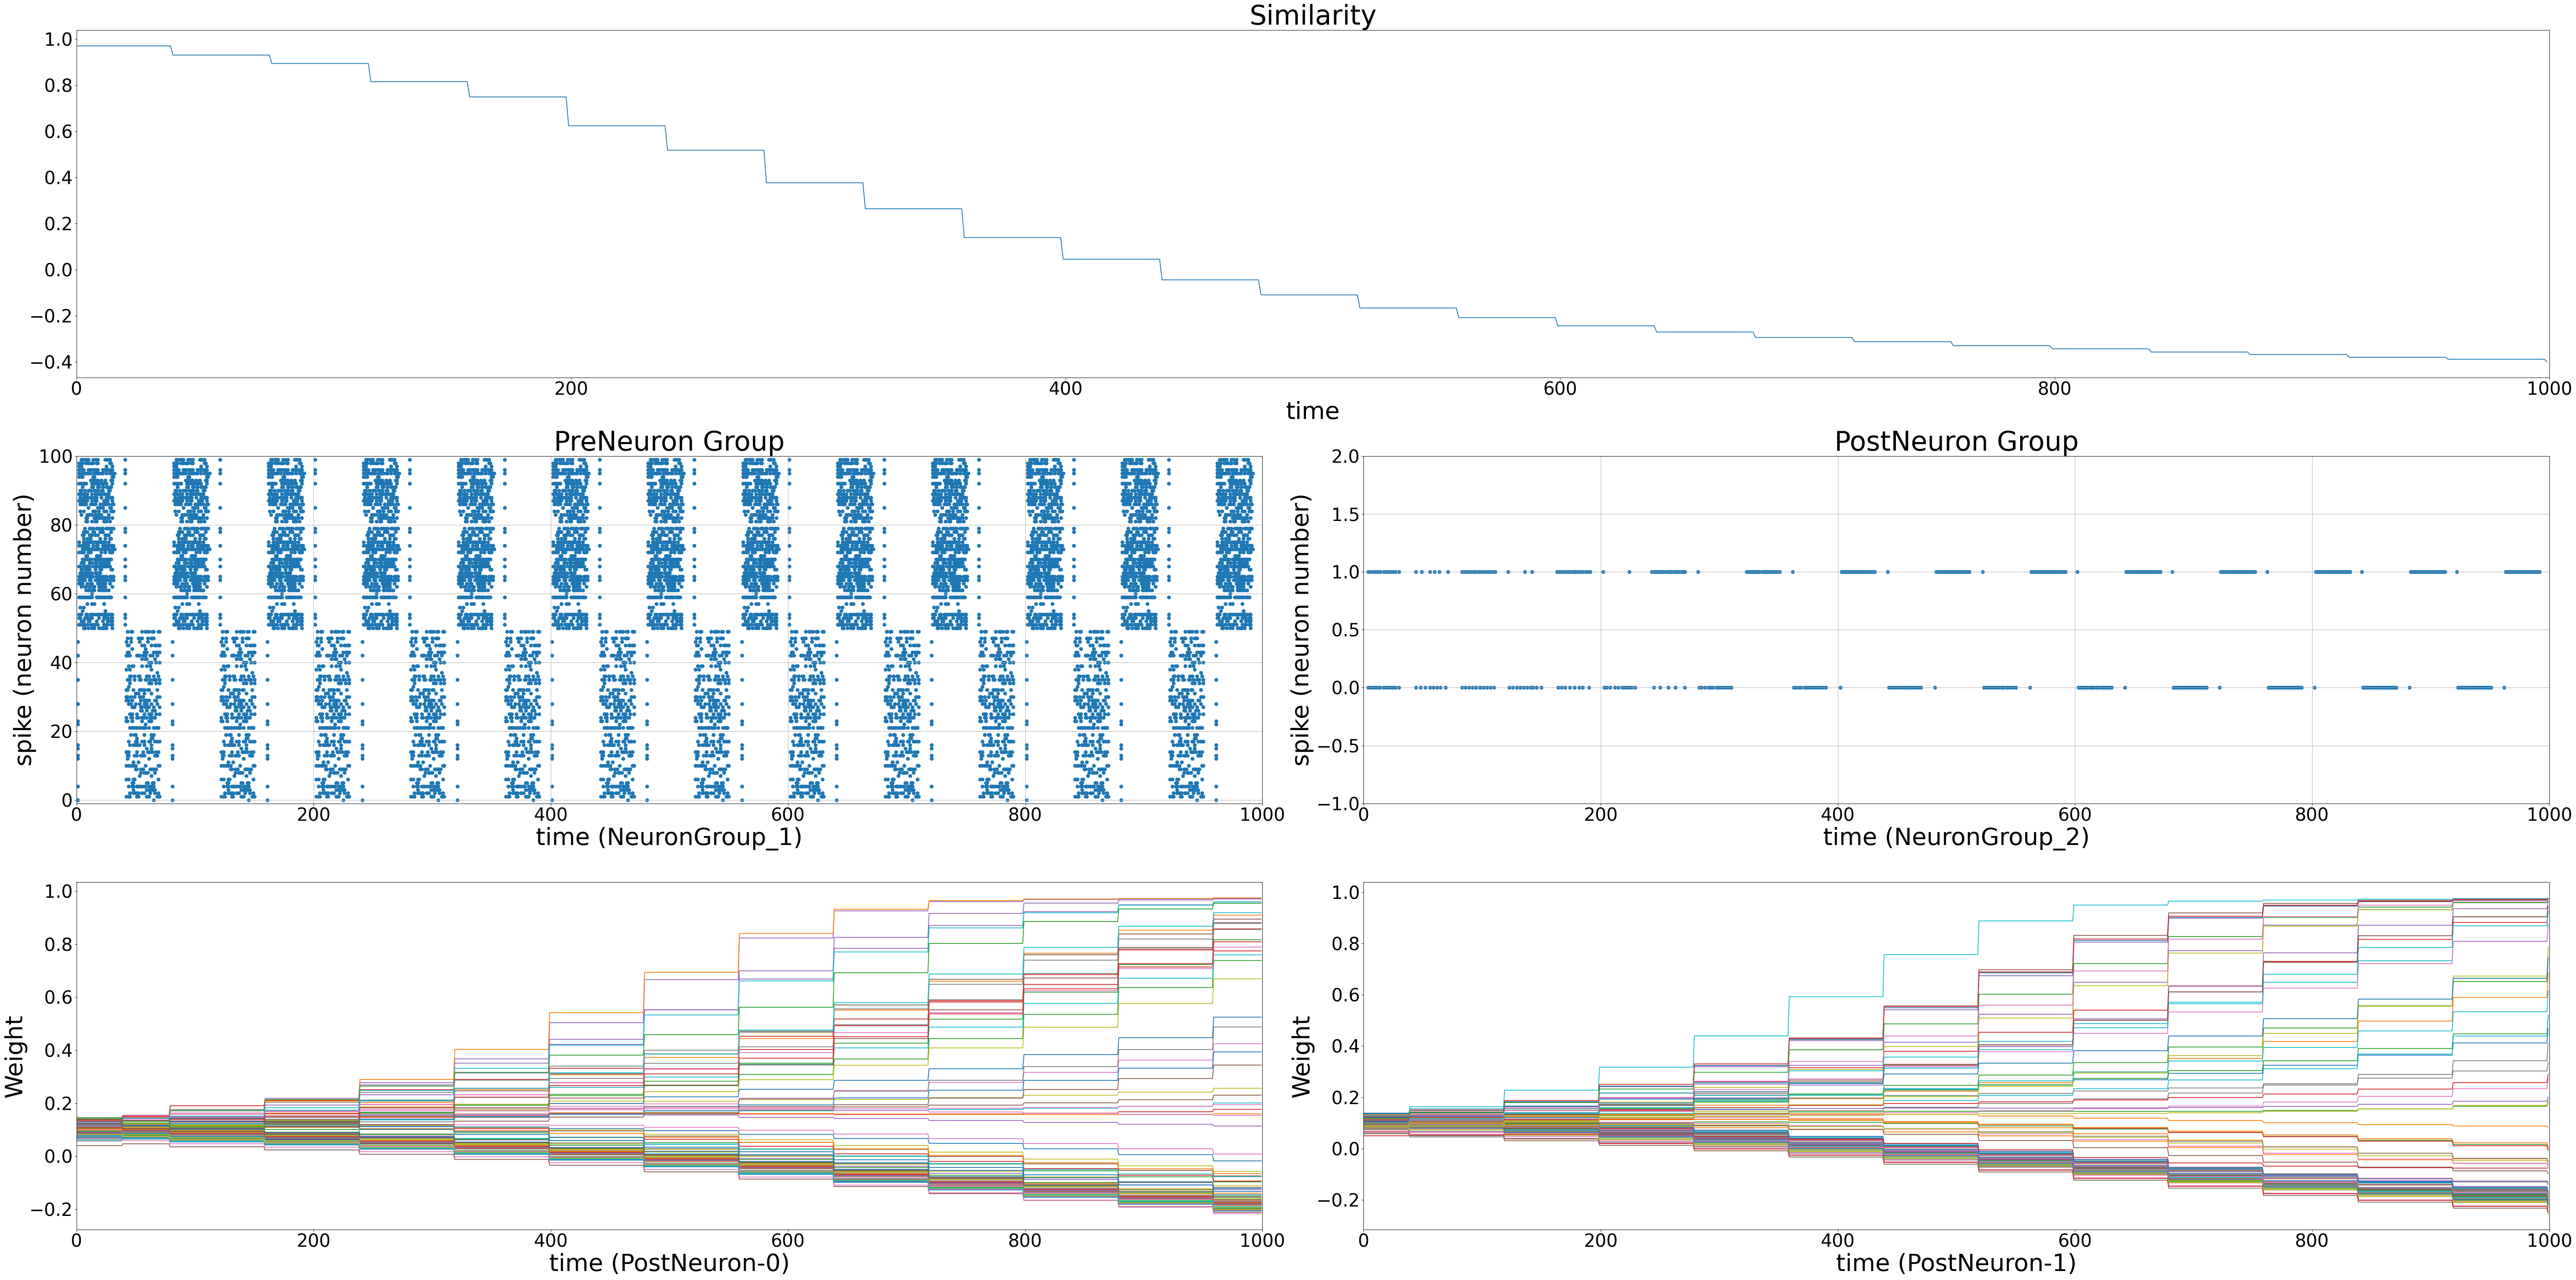

In [7]:
RSTDPSimulation()

1000xBatch: 1/1 (100%) 410.853ms


Network['Network_1', 'Network'](Neurons: tensor(102)|2 groups, Synapses: tensor(200)|1 groups){1:Timeresolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](100){5:ConstanceCurrent(current=0,)6:Dandrite()7:LIF(tau=10,R=1.5,u_rest=-67,u_reset=-75,threshold=-55,ratio=1,)8:PoissonDistribution(time=100,data=tensor([[ 7, 44, 21, 16, 42, 24, 11,  4, 31, 23, 27,  6, 13, 26, 40,  9, 25, 41,
         12, 20,  0, 49, 10, 46, 38, 45, 18, 37, 33, 35, 34, 17, 32,  2, 19, 36,
         29,  3, 22, 28, 14,  5, 47, 39,  8, 43, 15, 30,  1, 48,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 

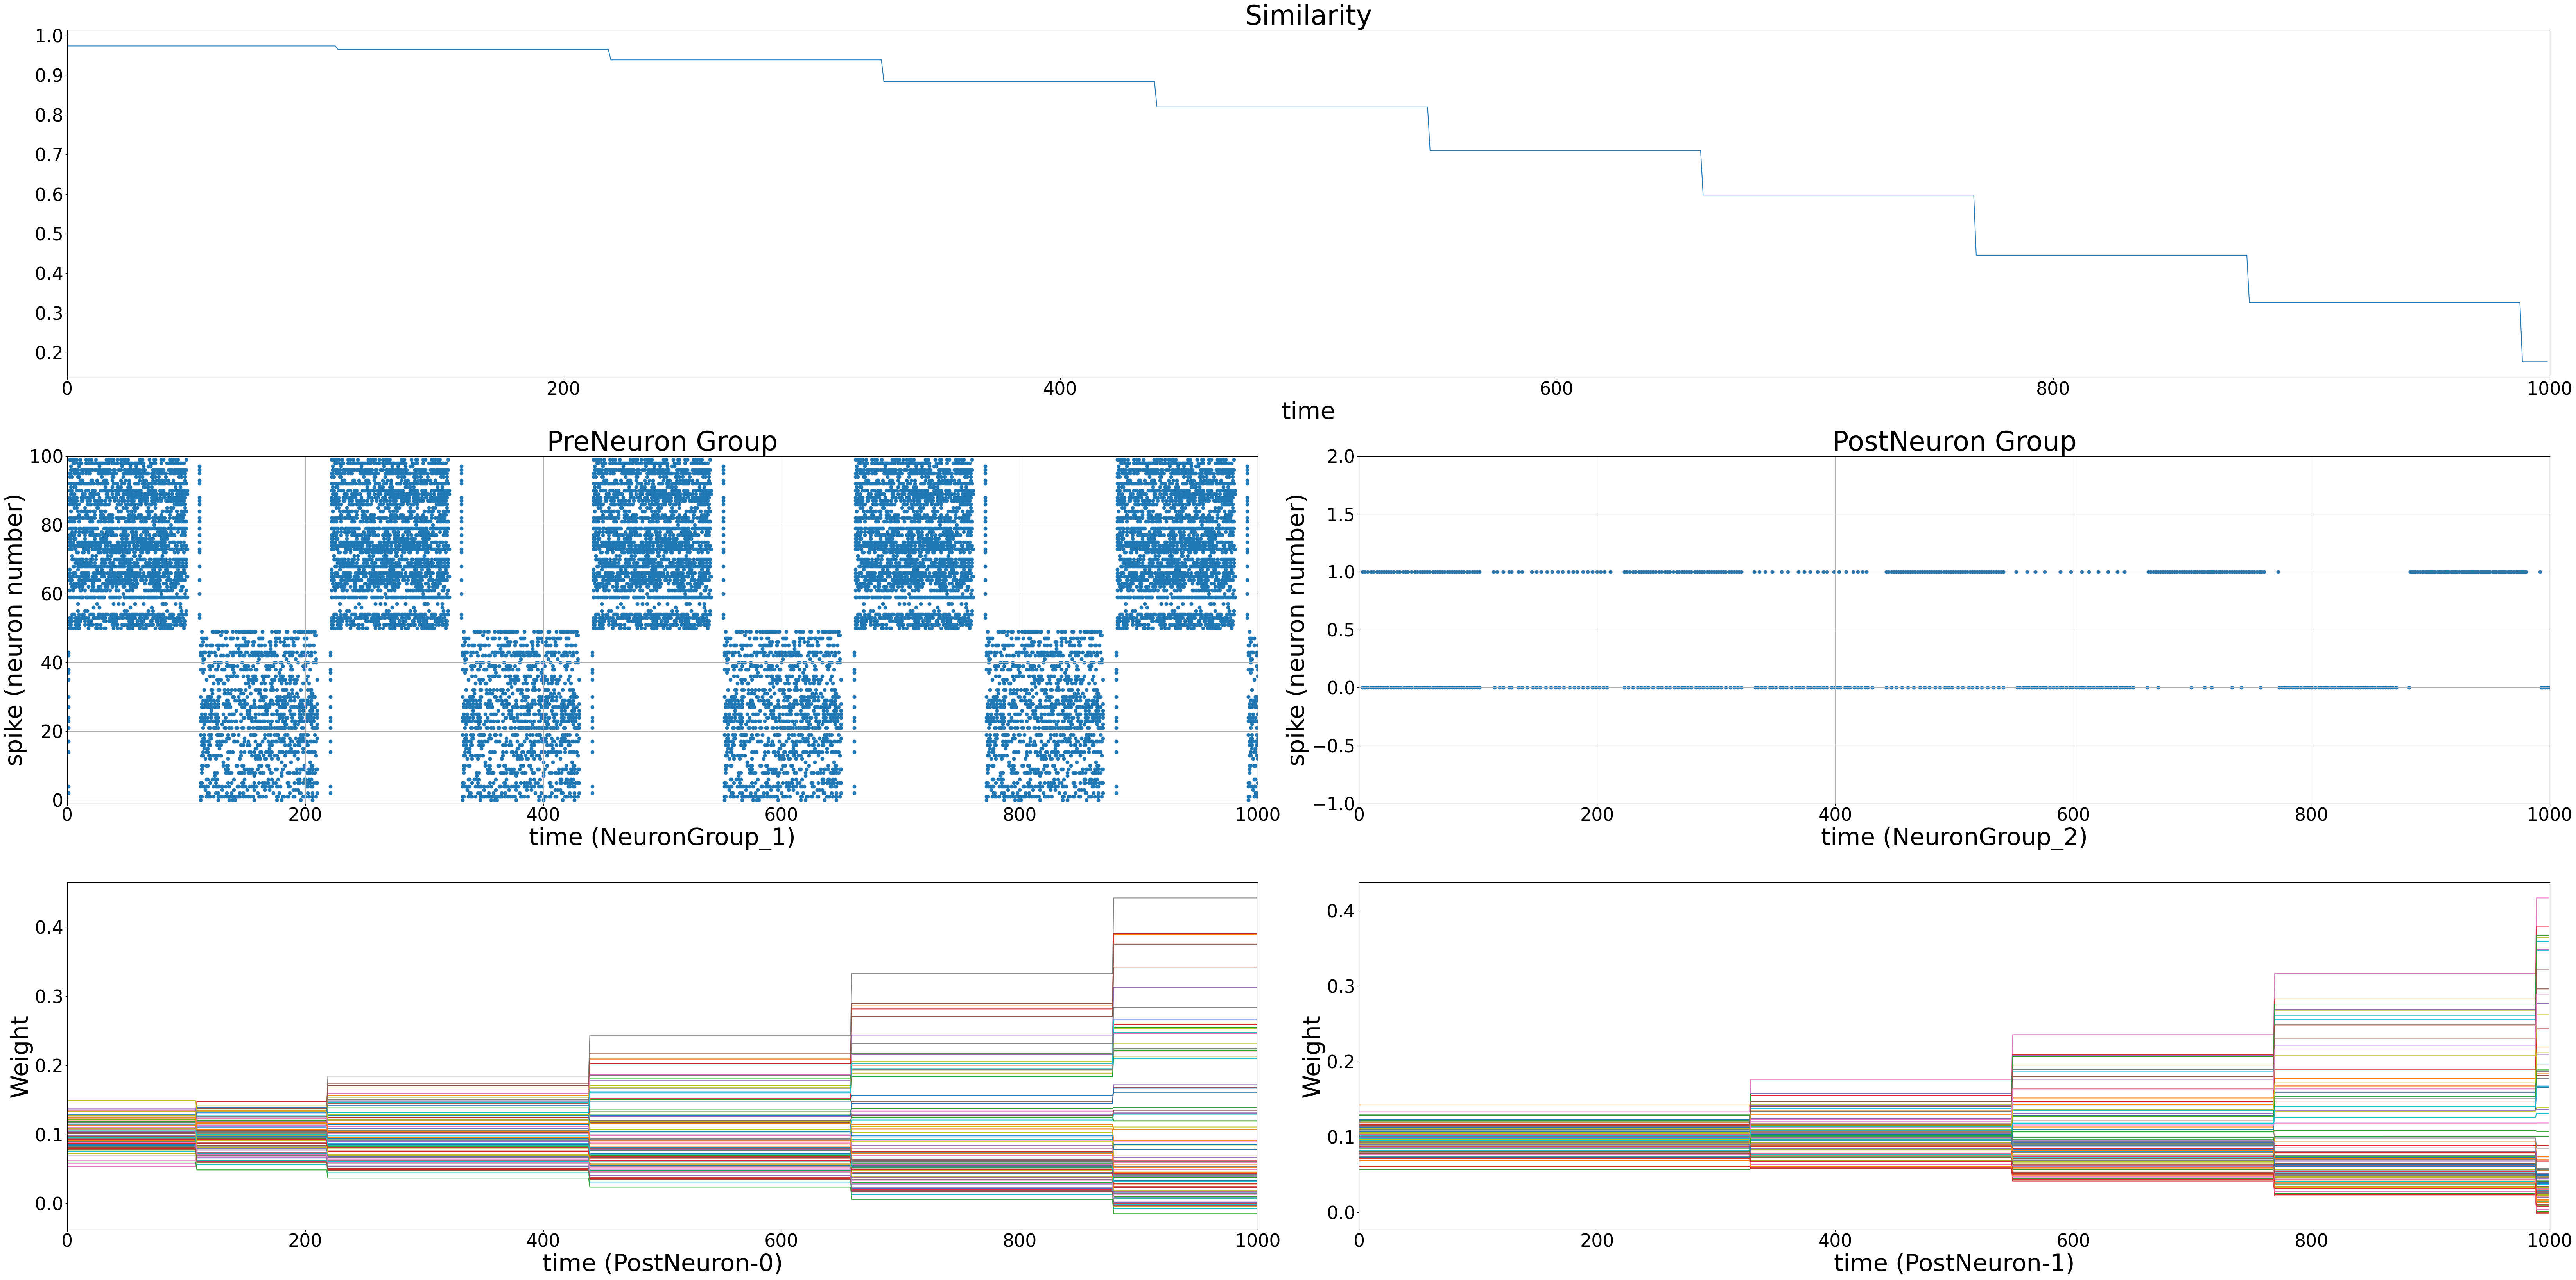

In [8]:
RSTDPSimulation(model=LIF(tau=10,
                        R=1.5,
                        u_rest=-67,
                        u_reset=-75,
                        threshold=-55,
                        ratio=1), 
                current=ConstanceCurrent(current=0), 
                dt = 1, 
                PLT = True,
                iteration_num = 1000,
                connection_pattern = FullConnectivitySecondOption(J0=10, standardـdeviation=20), 
                input_data = data1,
                input_time = 100
                )

1000xBatch: 1/1 (100%) 419.487ms


Network['Network_1', 'Network'](Neurons: tensor(102)|2 groups, Synapses: tensor(200)|1 groups){1:Timeresolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](100){5:ConstanceCurrent(current=0,)6:Dandrite()7:LIF(tau=10,R=1.5,u_rest=-67,u_reset=-75,threshold=-55,ratio=1,)8:PoissonDistribution(time=30,data=tensor([[ 20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,
          20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  74, 235, 235,  20,
          20,  20,  20,  20,  20, 235, 235, 235, 235, 235, 235,  20,  20,  20,
         235, 235,  75,  75,  75,  75, 235, 235,  20,  20, 235,  75,  75,  75,
          75,  75, 115, 235,  20,  20, 235,  75,  75, 150, 150,  75,  75, 235,
          20,  20, 235,  75, 150, 150, 150,  89,  75, 235,  20,  20, 235,  75,
         136, 150, 150,  75,  85, 235,  20,  20,  34, 235,  75,  75,  75,  75,
         235,  20],
        [ 12,  12,  12, 238, 238, 252, 237, 246, 238, 238,  50,  50,  50, 202,
         230, 184, 161, 174, 21

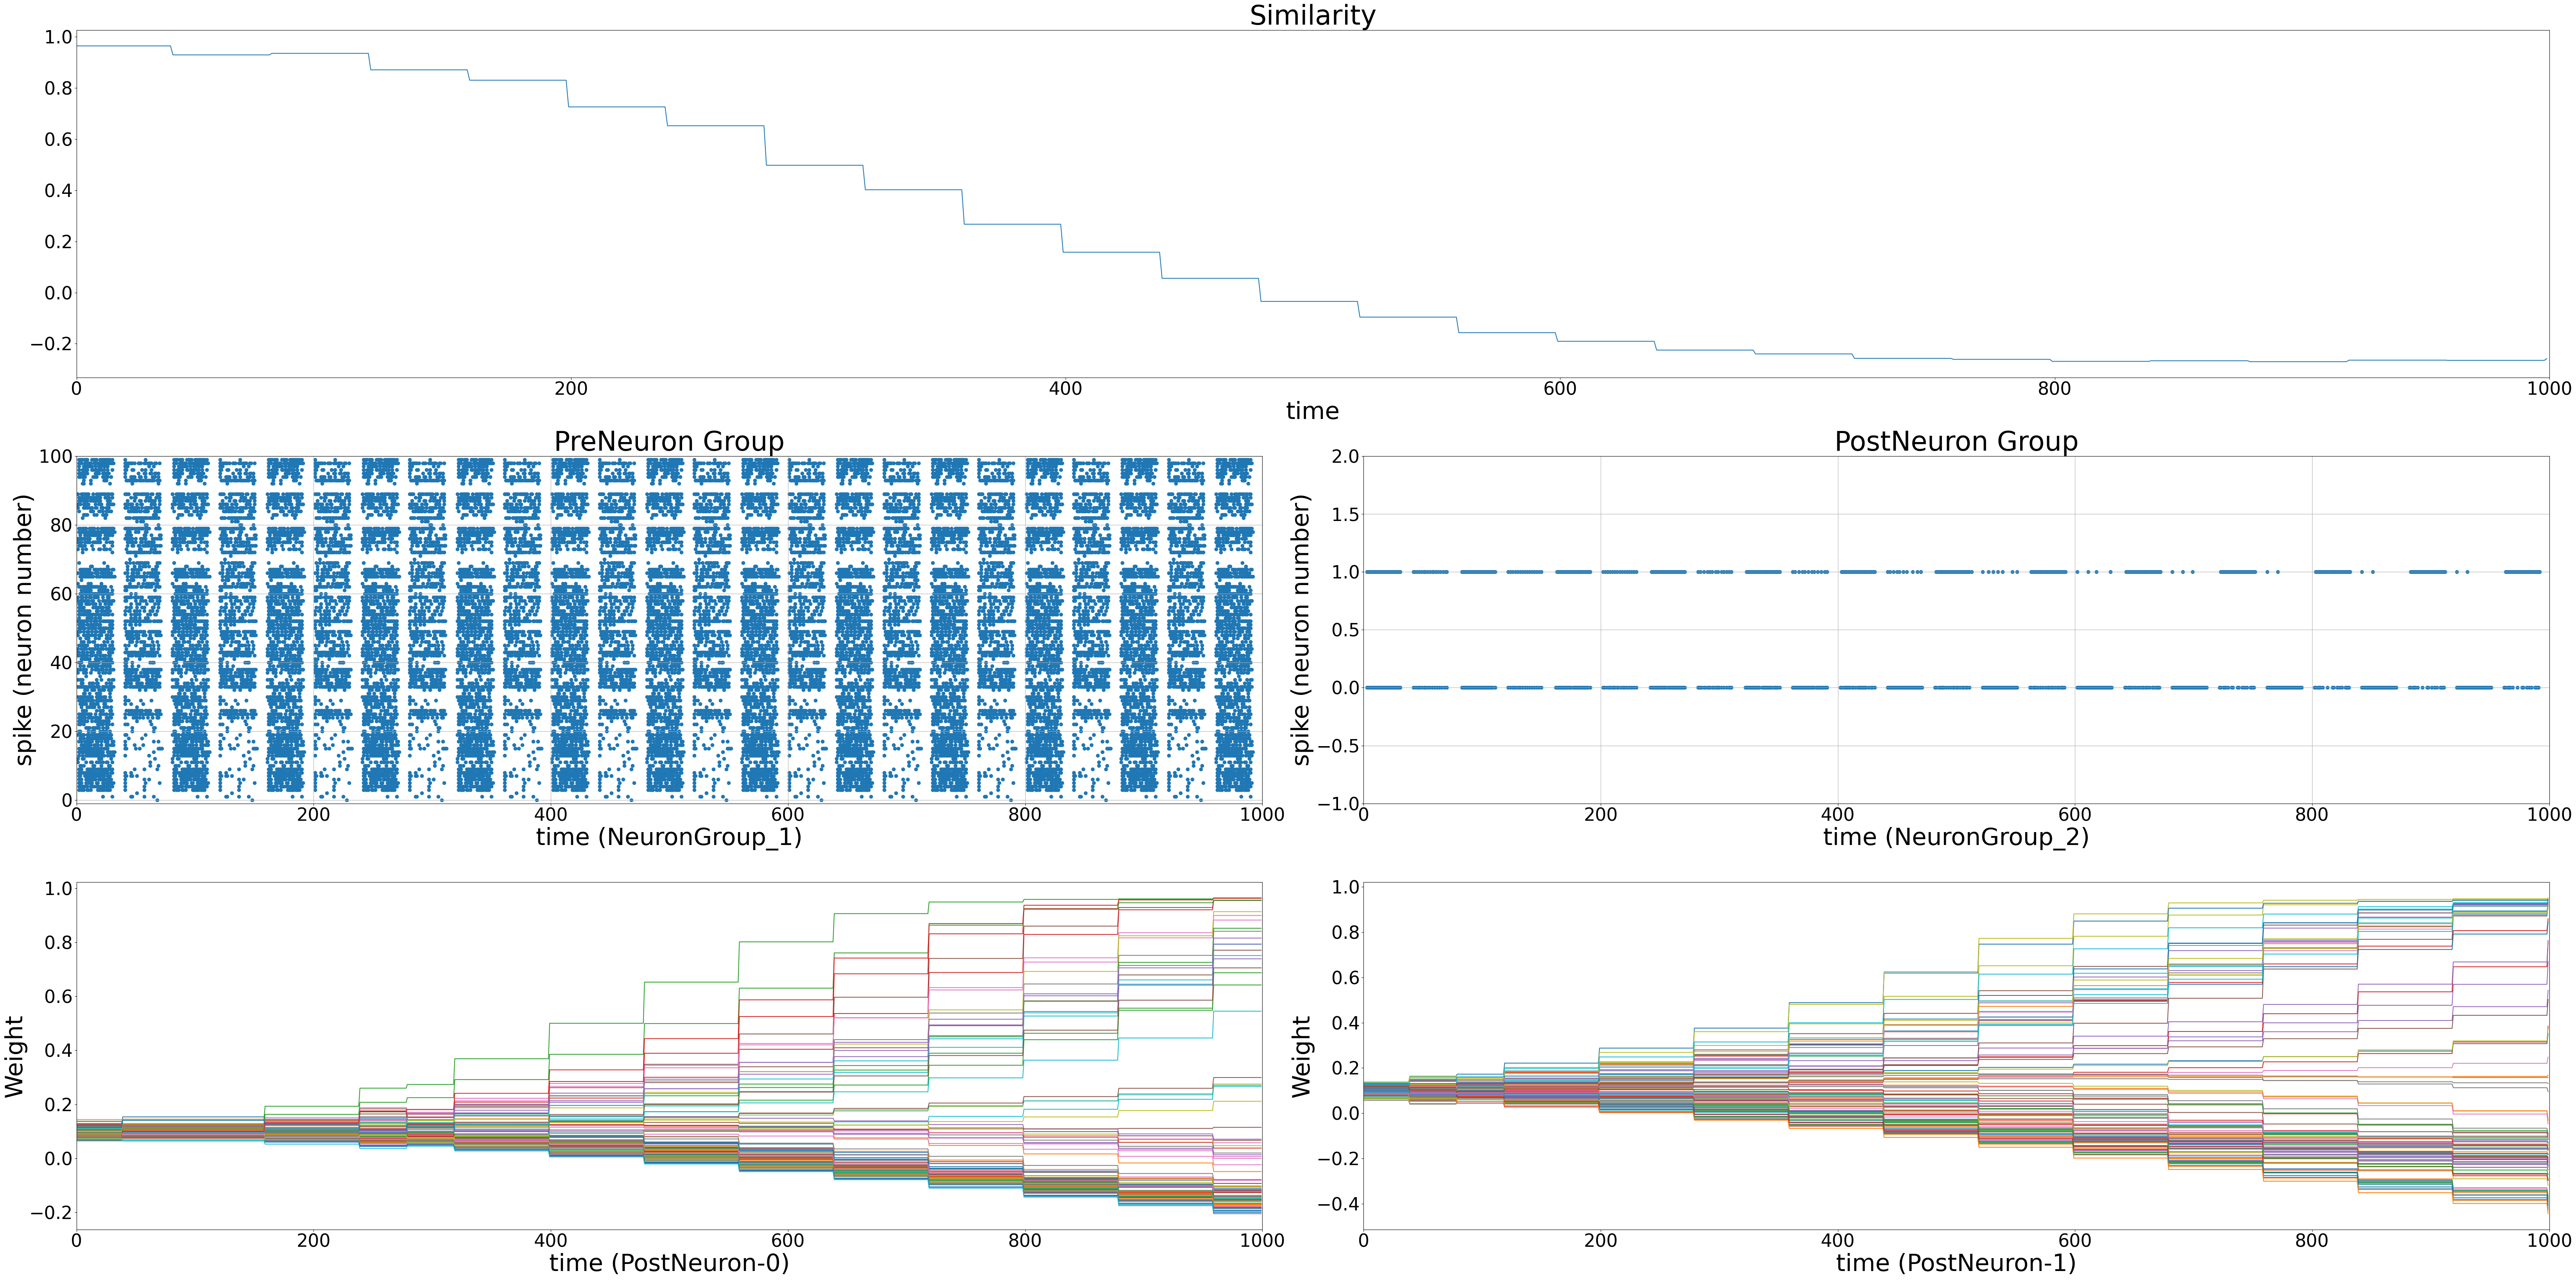

In [9]:
RSTDPSimulation(model=LIF(tau=10,
                        R=1.5,
                        u_rest=-67,
                        u_reset=-75,
                        threshold=-55,
                        ratio=1), 
                current=ConstanceCurrent(current=0), 
                dt = 1, 
                PLT = True,
                iteration_num = 1000,
                connection_pattern = FullConnectivitySecondOption(J0=10, standardـdeviation=20), 
                input_data = data2,
                positive_tau = 2,
                negative_tau = 2,
                A_negative = 0.2,
                A_positive = 5,
                reward = 0.5 ,
                punishment = -0.5 ,
                normalize = True,
                input_time = 30,
                PostNG_size = 2,
                )

1000xBatch: 1/1 (100%) 439.114ms


Network['Network_1', 'Network'](Neurons: tensor(102)|2 groups, Synapses: tensor(200)|1 groups){1:Timeresolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](100){5:ConstanceCurrent(current=0,)6:Dandrite()7:LIF(tau=10,R=1.5,u_rest=-67,u_reset=-75,threshold=-55,ratio=1,)8:PoissonDistribution(time=10,data=tensor([[ 20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,
          20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  74, 235, 235,  20,
          20,  20,  20,  20,  20, 235, 235, 235, 235, 235, 235,  20,  20,  20,
         235, 235,  75,  75,  75,  75, 235, 235,  20,  20, 235,  75,  75,  75,
          75,  75, 115, 235,  20,  20, 235,  75,  75, 150, 150,  75,  75, 235,
          20,  20, 235,  75, 150, 150, 150,  89,  75, 235,  20,  20, 235,  75,
         136, 150, 150,  75,  85, 235,  20,  20,  34, 235,  75,  75,  75,  75,
         235,  20],
        [ 12,  12,  12, 238, 238, 252, 237, 246, 238, 238,  50,  50,  50, 202,
         230, 184, 161, 174, 21

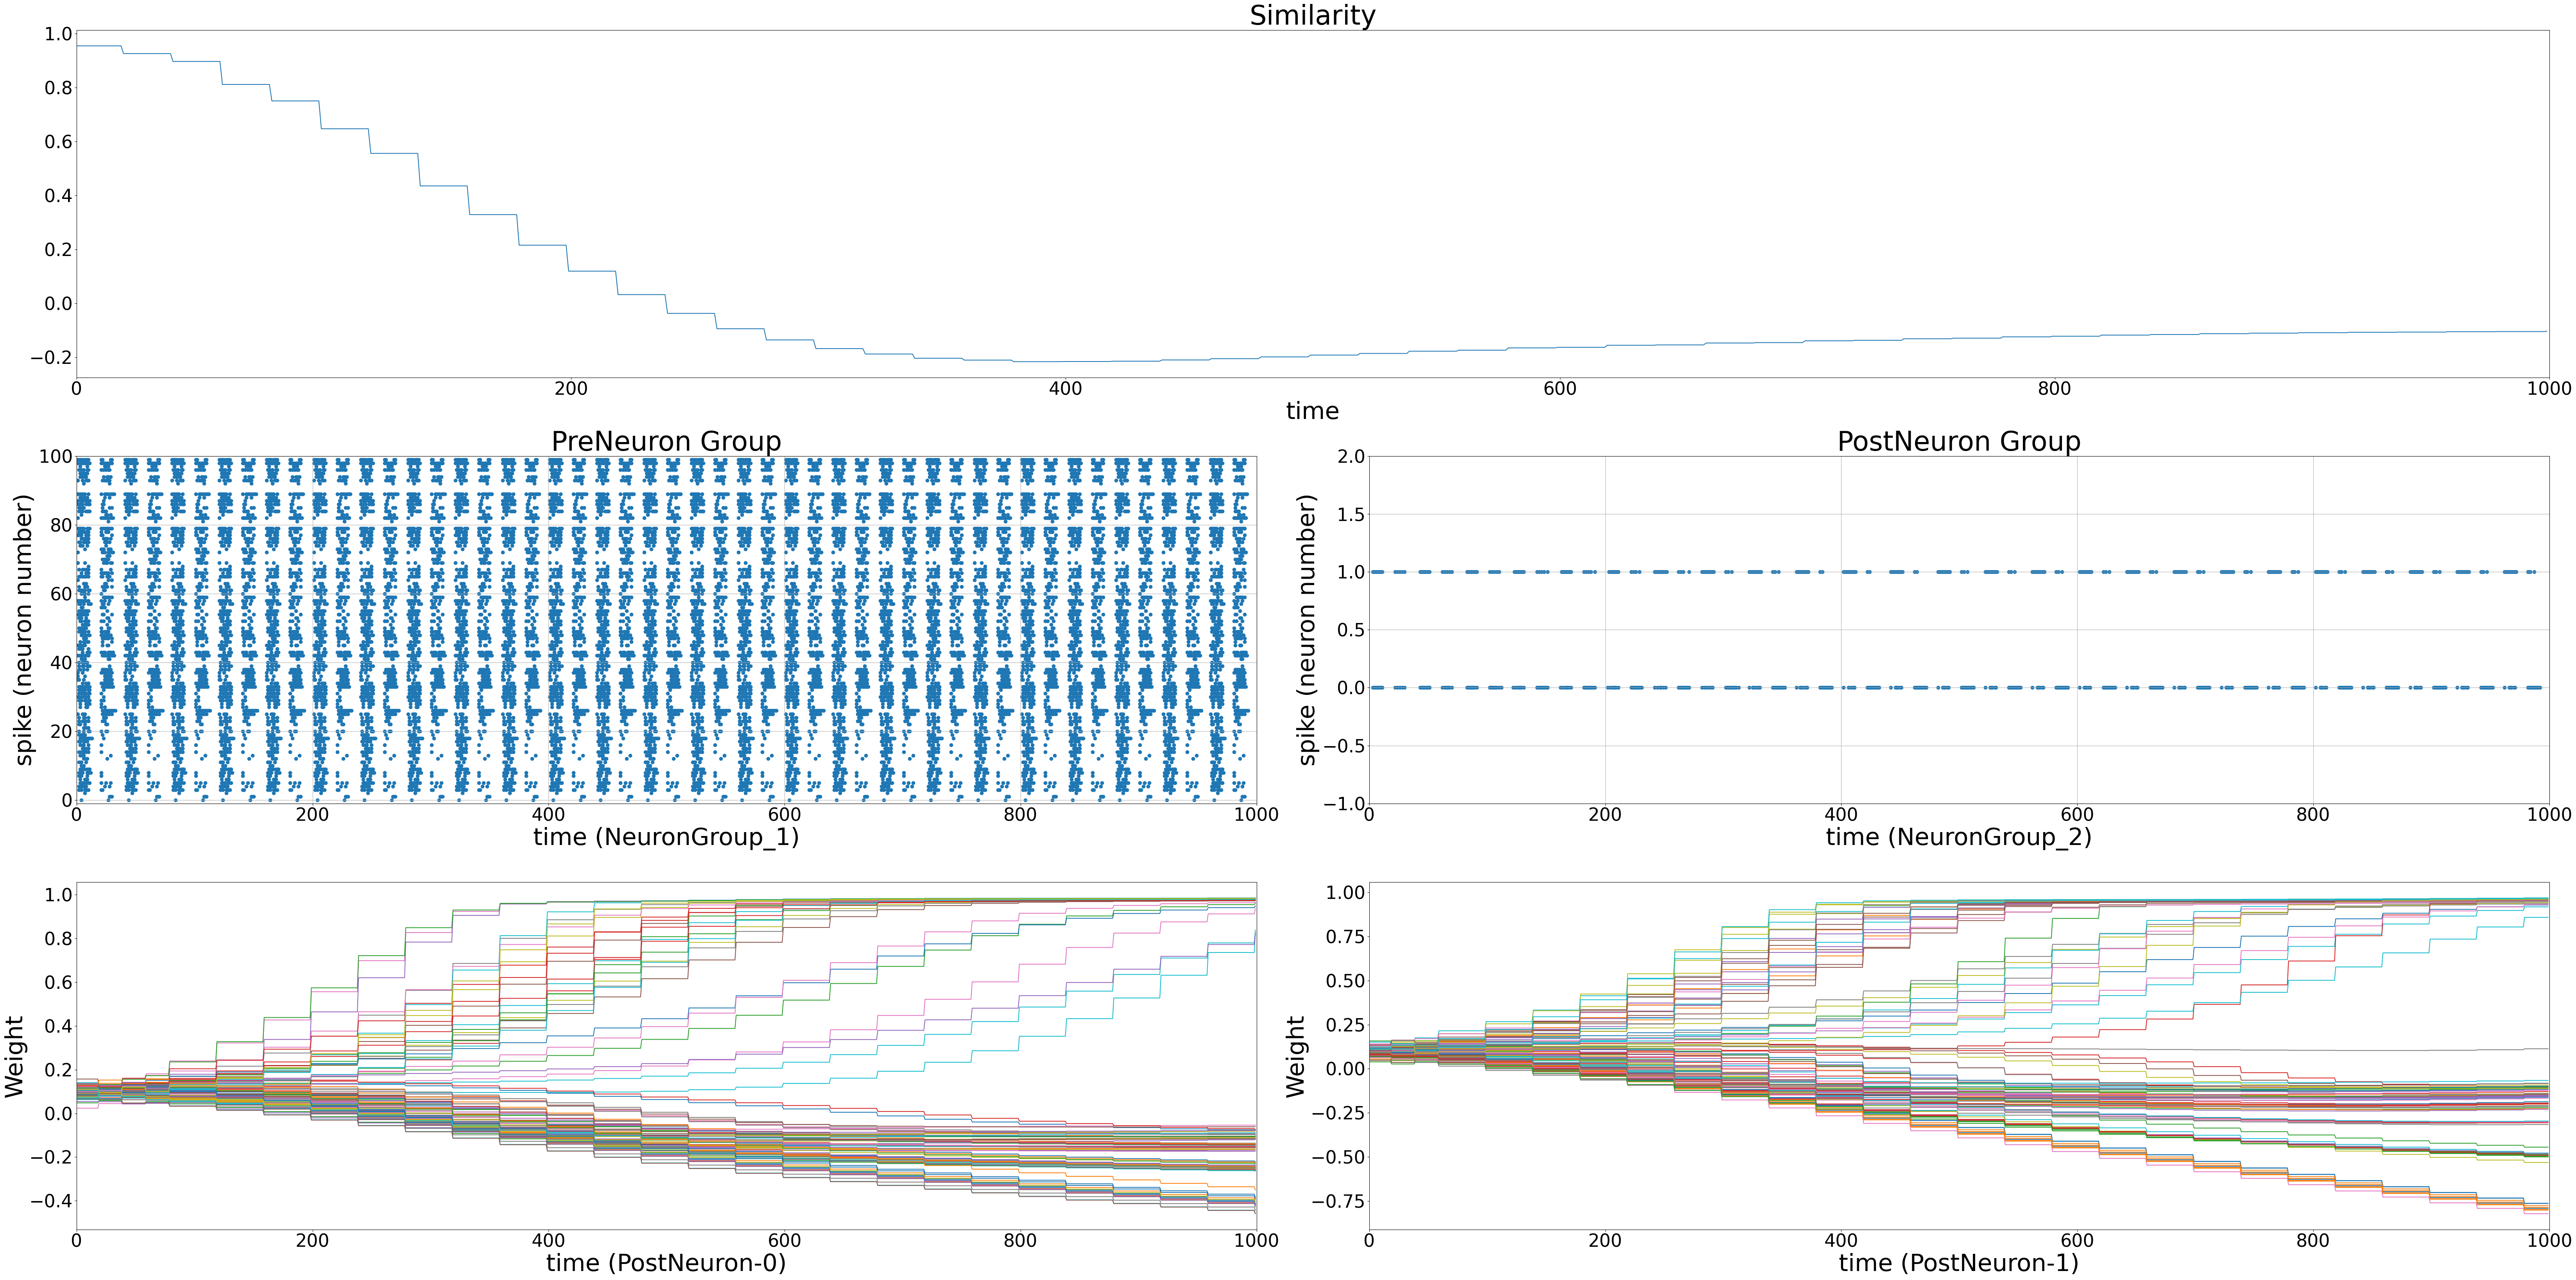

In [10]:
RSTDPSimulation(model=LIF(tau=10,
                        R=1.5,
                        u_rest=-67,
                        u_reset=-75,
                        threshold=-55,
                        ratio=1), 
                current=ConstanceCurrent(current=0), 
                dt = 1, 
                PLT = True,
                iteration_num = 1000,
                connection_pattern = FullConnectivitySecondOption(J0=10, standardـdeviation=20), 
                input_data = data2,
                positive_tau = 2,
                negative_tau = 2,
                A_negative = 0.2,
                A_positive = 5,
                reward = 0.5 ,
                punishment = -0.5 ,
                normalize = True,
                input_time = 10,
                PostNG_size = 2,
                )

100xBatch: 1/1 (100%) 34.642ms


Network['Network_1', 'Network'](Neurons: tensor(102)|2 groups, Synapses: tensor(200)|1 groups){1:Timeresolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](100){5:ConstanceCurrent(current=0,)6:Dandrite()7:LIF(tau=10,R=1.5,u_rest=-67,u_reset=-75,threshold=-55,ratio=1,)8:PoissonDistribution(time=10,data=tensor([[ 7, 44, 21, 16, 42, 24, 11,  4, 31, 23, 27,  6, 13, 26, 40,  9, 25, 41,
         12, 20,  0, 49, 10, 46, 38, 45, 18, 37, 33, 35, 34, 17, 32,  2, 19, 36,
         29,  3, 22, 28, 14,  5, 47, 39,  8, 43, 15, 30,  1, 48,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 3

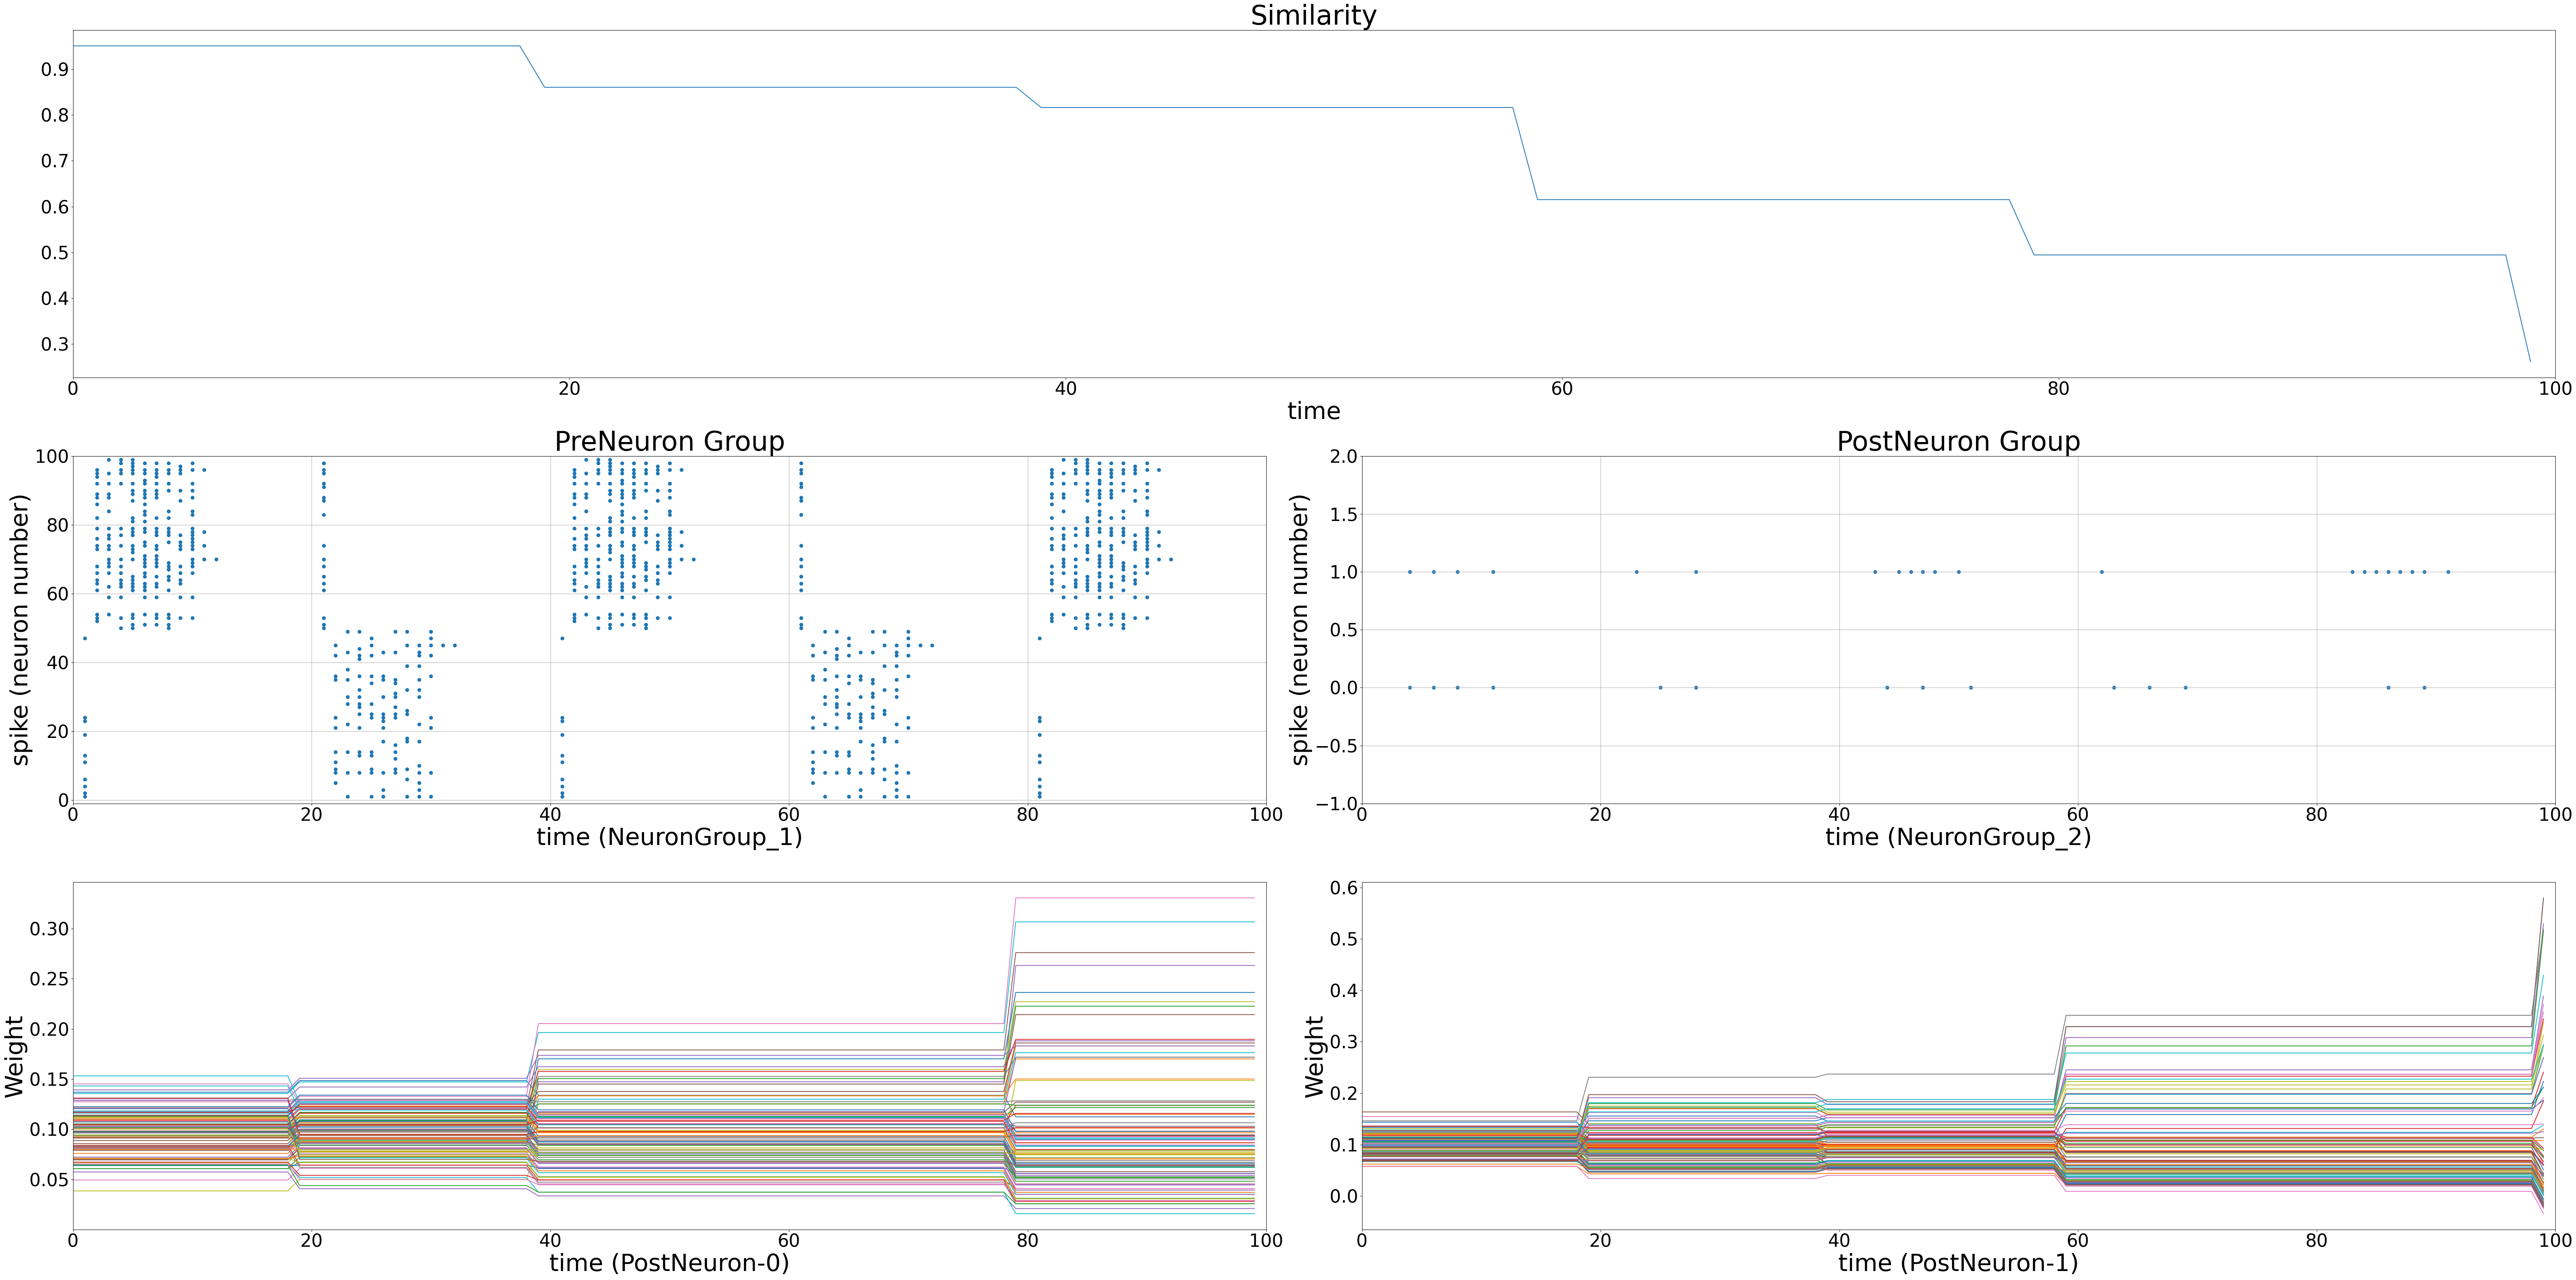

In [11]:
RSTDPSimulation(model=LIF(tau=10,
                        R=1.5,
                        u_rest=-67,
                        u_reset=-75,
                        threshold=-55,
                        ratio=1), 
                current=ConstanceCurrent(current=0), 
                dt = 1, 
                PLT = True,
                iteration_num = 100,
                connection_pattern = FullConnectivitySecondOption(J0=10, standardـdeviation=20), 
                input_data = data1,
                positive_tau = 10,
                negative_tau = 5,
                A_negative = 2,
                A_positive = 15,
                reward = 1 ,
                punishment = -0.5 ,
                normalize = True,
                input_time = 10,
                PostNG_size = 2,
                )

100xBatch: 1/1 (100%) 36.202ms


Network['Network_1', 'Network'](Neurons: tensor(102)|2 groups, Synapses: tensor(200)|1 groups){1:Timeresolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](100){5:ConstanceCurrent(current=0,)6:Dandrite()7:LIF(tau=10,R=1.5,u_rest=-67,u_reset=-75,threshold=-55,ratio=1,)8:PoissonDistribution(time=10,data=tensor([[ 7, 44, 21, 16, 42, 24, 11,  4, 31, 23, 27,  6, 13, 26, 40,  9, 25, 41,
         12, 20,  0, 49, 10, 46, 38, 45, 18, 37, 33, 35, 34, 17, 32,  2, 19, 36,
         29,  3, 22, 28, 14,  5, 47, 39,  8, 43, 15, 30,  1, 48,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 3

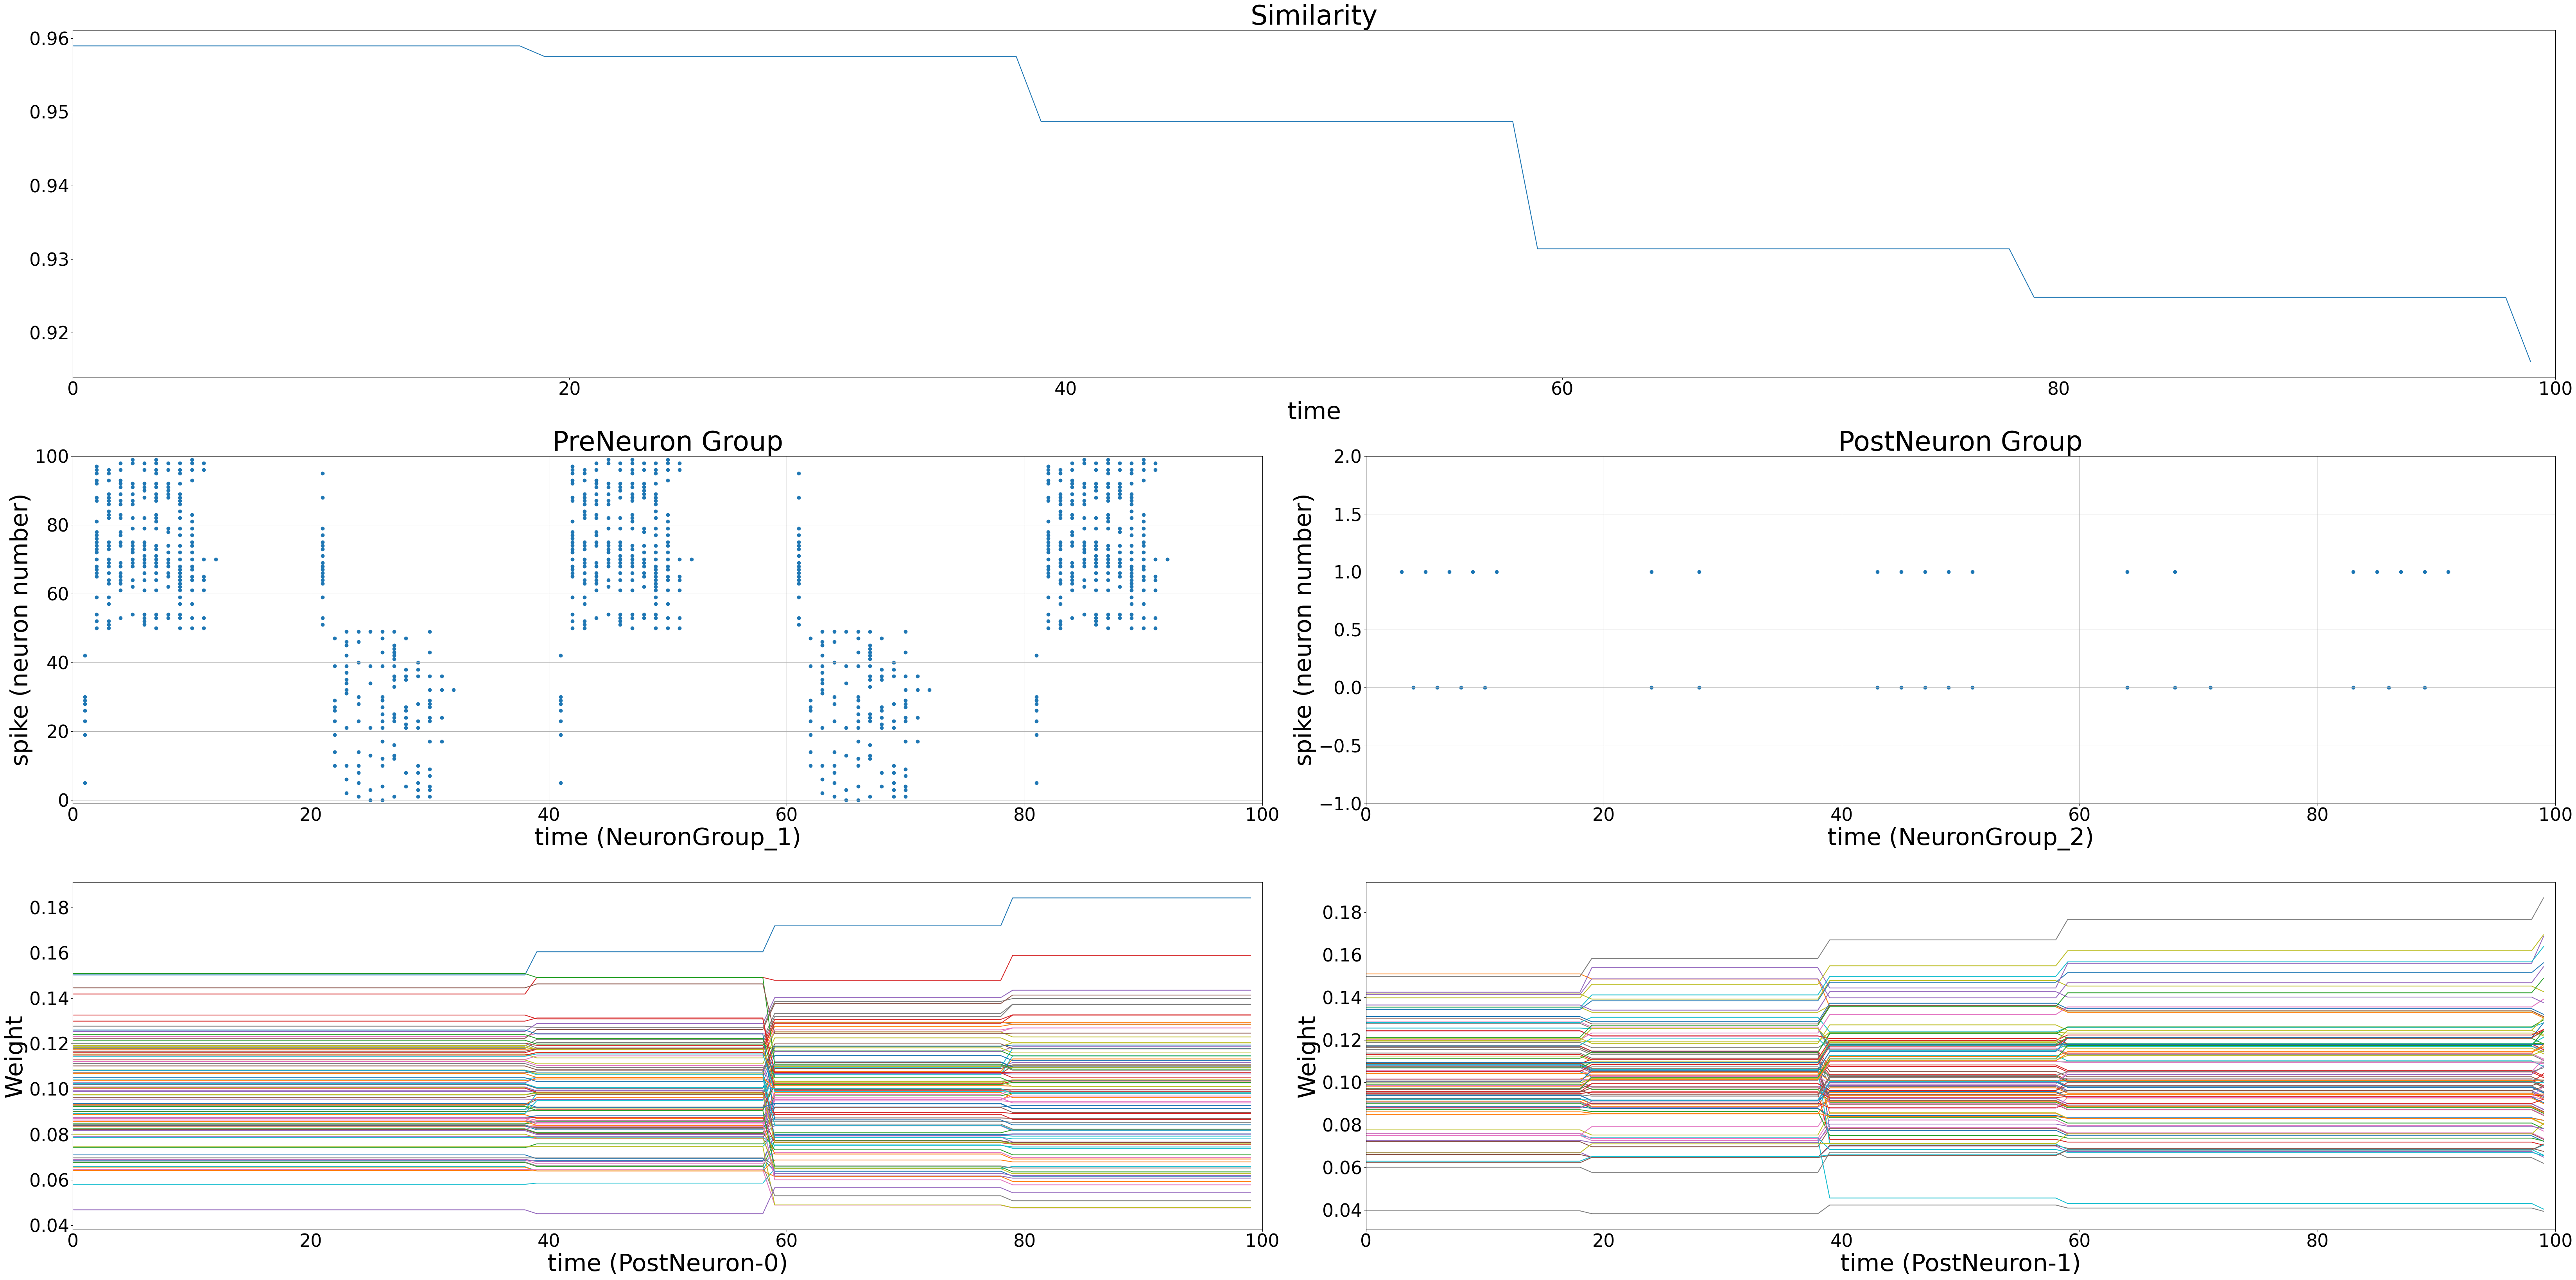

In [12]:
RSTDPSimulation(model=LIF(tau=10,
                        R=1.5,
                        u_rest=-67,
                        u_reset=-75,
                        threshold=-55,
                        ratio=1), 
                current=ConstanceCurrent(current=0), 
                dt = 1, 
                PLT = True,
                iteration_num = 100,
                connection_pattern = FullConnectivitySecondOption(J0=10, standardـdeviation=20), 
                input_data = data1,
                positive_tau = 10,
                negative_tau = 5,
                A_negative = 2,
                A_positive = 15,
                reward = 0.1 ,
                punishment = -0.5 ,
                normalize = True,
                input_time = 10,
                PostNG_size = 2,
                )

1000xBatch: 1/1 (100%) 446.434ms


Network['Network_1', 'Network'](Neurons: tensor(102)|2 groups, Synapses: tensor(200)|1 groups){1:Timeresolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](100){5:ConstanceCurrent(current=0,)6:Dandrite()7:LIF(tau=10,R=1.5,u_rest=-67,u_reset=-75,threshold=-55,ratio=1,)8:PoissonDistribution(time=30,data=tensor([[ 20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,
          20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  74, 235, 235,  20,
          20,  20,  20,  20,  20, 235, 235, 235, 235, 235, 235,  20,  20,  20,
         235, 235,  75,  75,  75,  75, 235, 235,  20,  20, 235,  75,  75,  75,
          75,  75, 115, 235,  20,  20, 235,  75,  75, 150, 150,  75,  75, 235,
          20,  20, 235,  75, 150, 150, 150,  89,  75, 235,  20,  20, 235,  75,
         136, 150, 150,  75,  85, 235,  20,  20,  34, 235,  75,  75,  75,  75,
         235,  20],
        [ 12,  12,  12, 238, 238, 252, 237, 246, 238, 238,  50,  50,  50, 202,
         230, 184, 161, 174, 21

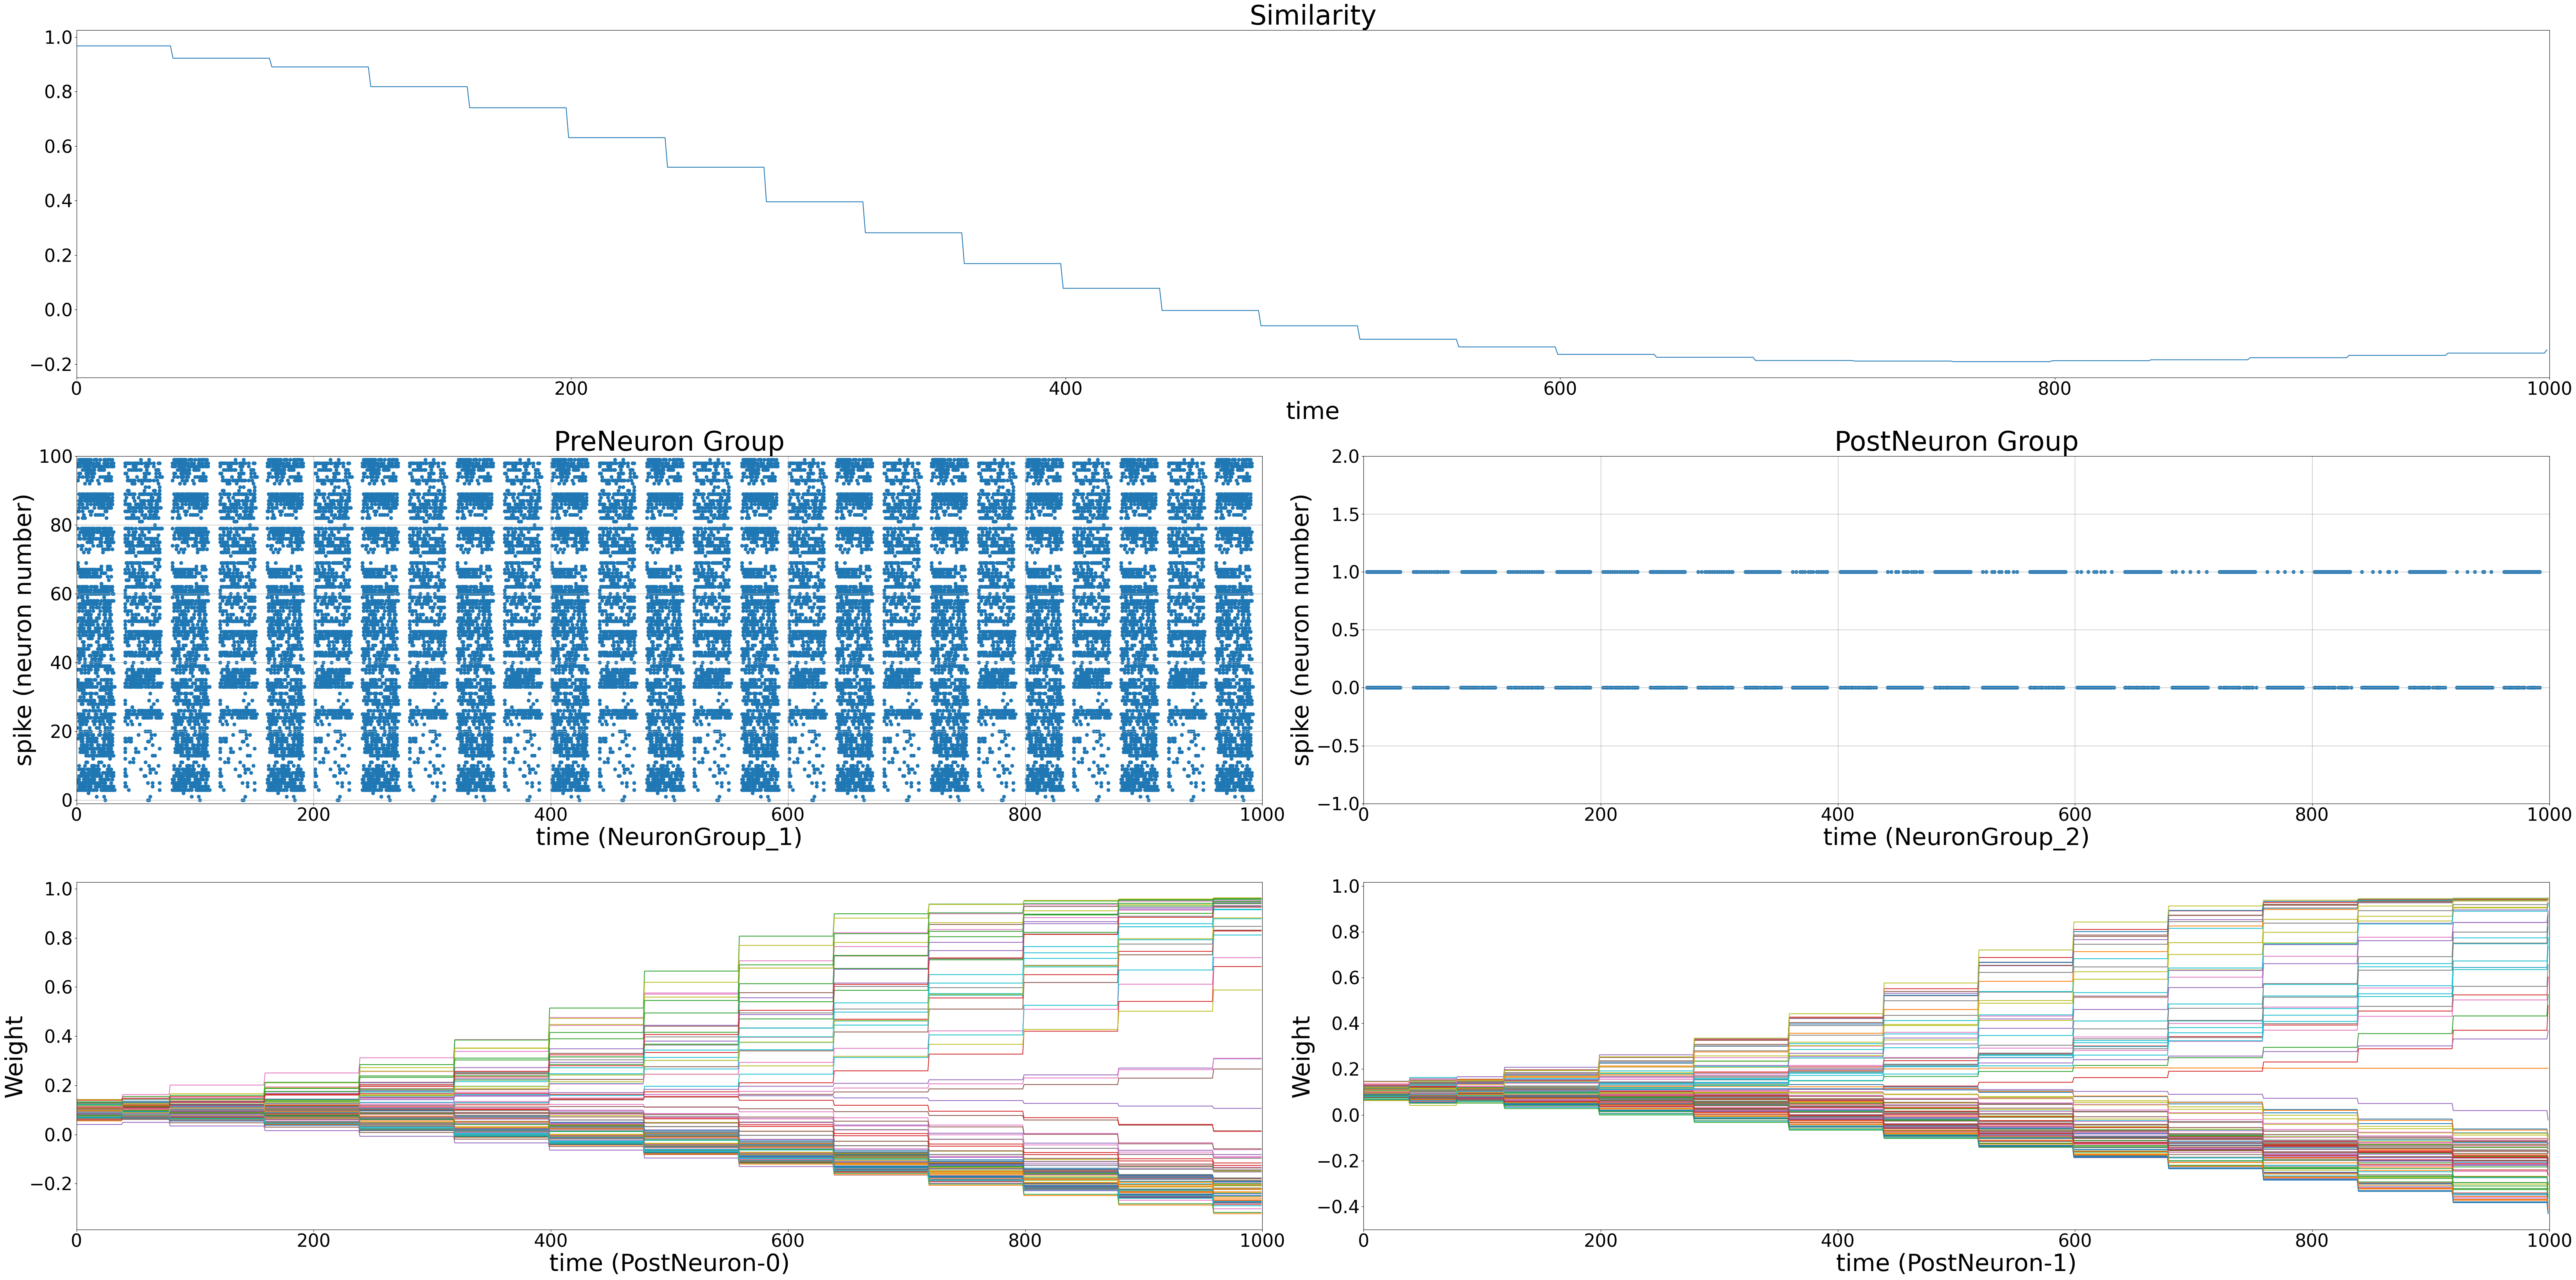

In [15]:
RSTDPSimulation(model=LIF(tau=10,
                        R=1.5,
                        u_rest=-67,
                        u_reset=-75,
                        threshold=-55,
                        ratio=1), 
                current=ConstanceCurrent(current=0), 
                dt = 1, 
                PLT = True,
                iteration_num = 1000,
                connection_pattern = FullConnectivitySecondOption(J0=10, standardـdeviation=20), 
                input_data = data3,
                positive_tau = 2,
                negative_tau = 2,
                A_negative = 0.2,
                A_positive = 5,
                reward = 0.5 ,
                punishment = -0.5 ,
                normalize = True,
                input_time = 30,
                PostNG_size = 2,
                )

1000xBatch: 1/1 (100%) 434.912ms


Network['Network_1', 'Network'](Neurons: tensor(102)|2 groups, Synapses: tensor(200)|1 groups){1:Timeresolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](100){5:ConstanceCurrent(current=0,)6:Dandrite()7:LIF(tau=10,R=1.5,u_rest=-67,u_reset=-75,threshold=-55,ratio=1,)8:PoissonDistribution(time=25,data=tensor([[ 20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,
          20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  74, 235, 235,  20,
          20,  20,  20,  20,  20, 235, 235, 235, 235, 235, 235,  20,  20,  20,
         235, 235,  75,  75,  75,  75, 235, 235,  20,  20, 235,  75,  75,  75,
          75,  75, 115, 235,  20,  20, 235,  75,  75, 150, 150,  75,  75, 235,
          20,  20, 235,  75, 150, 150, 150,  89,  75, 235,  20,  20, 235,  75,
         136, 150, 150,  75,  85, 235,  20,  20,  34, 235,  75,  75,  75,  75,
         235,  20],
        [ 12,  12,  12, 238, 238, 252, 237, 246, 238, 238,  50,  50,  50, 202,
         230, 184, 161, 174, 21

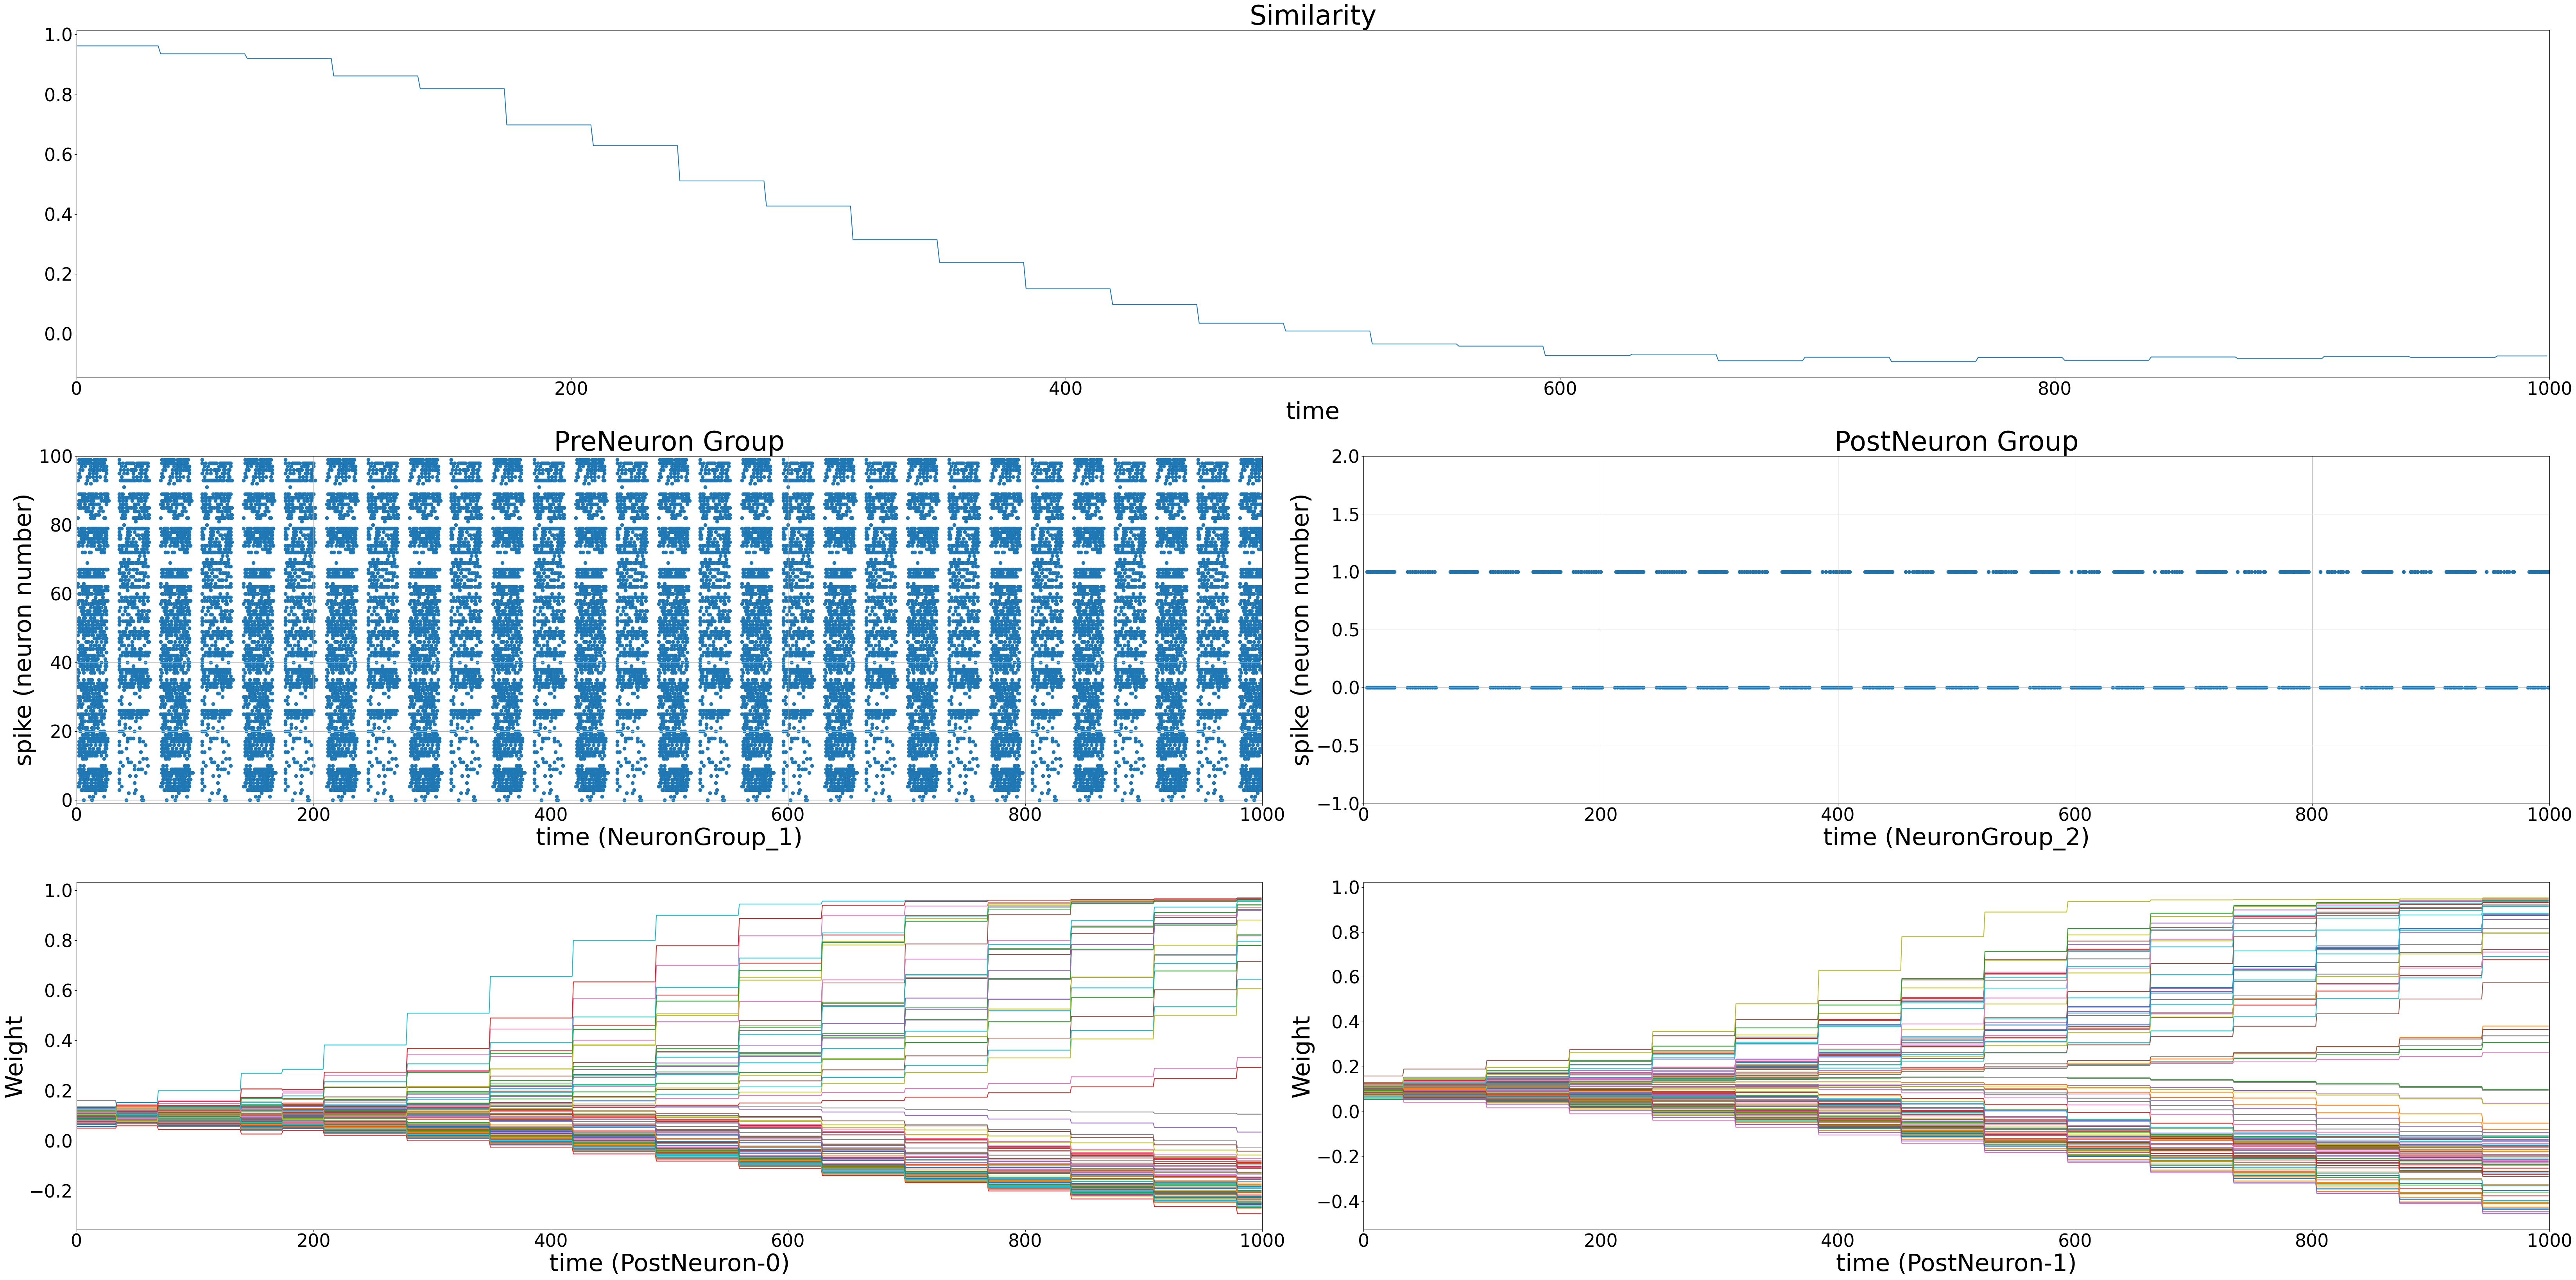

In [17]:
RSTDPSimulation(model=LIF(tau=10,
                        R=1.5,
                        u_rest=-67,
                        u_reset=-75,
                        threshold=-55,
                        ratio=1), 
                current=ConstanceCurrent(current=0), 
                dt = 1, 
                PLT = True,
                iteration_num = 1000,
                connection_pattern = FullConnectivitySecondOption(J0=10, standardـdeviation=20), 
                input_data = data3,
                positive_tau = 2,
                negative_tau = 2,
                A_negative = 0.2,
                A_positive = 5,
                reward = 0.5 ,
                punishment = -0.5 ,
                normalize = True,
                input_time = 25,
                PostNG_size = 2,
                )